In [21]:
from __future__ import annotations

import pathlib
import re

import polars
import seaborn
from matplotlib import pyplot as plt
from proxystore.utils.data import readable_to_bytes

_ = polars.Config.set_tbl_rows(100)

In [22]:
def load_data(filepath: pathlib.Path) -> polars.DataFrame:
    pattern = re.compile(
        r'Completed run \d+/\d+: size = (\d+\w+); time = ([\d.]+)',
    )
    runs = []
    with open(filepath) as f:
        for line in f:
            matched = pattern.search(line)
            if matched:
                size, time = matched.groups()
                runs.append(
                    {
                        'size': readable_to_bytes(size),
                        'time': float(time),
                    },
                )

    return polars.from_dicts(runs)

In [23]:
directory = pathlib.Path('../data/autogen')
autogen_runs = load_data(directory / 'autogen.log').with_columns(
    polars.lit('autogen').alias('framework'),
)
academy_runs = load_data(directory / 'academy.log').with_columns(
    polars.lit('academy').alias('framework'),
)
runs = polars.concat([autogen_runs, academy_runs]).sort('framework', 'size')

In [24]:
runs

size,time,framework
i64,f64,str
1000,0.006279,"""academy"""
1000,0.006223,"""academy"""
1000,0.00614,"""academy"""
1000,0.006181,"""academy"""
1000,0.007932,"""academy"""
10000,0.006085,"""academy"""
10000,0.006268,"""academy"""
10000,0.00649,"""academy"""
10000,0.006369,"""academy"""


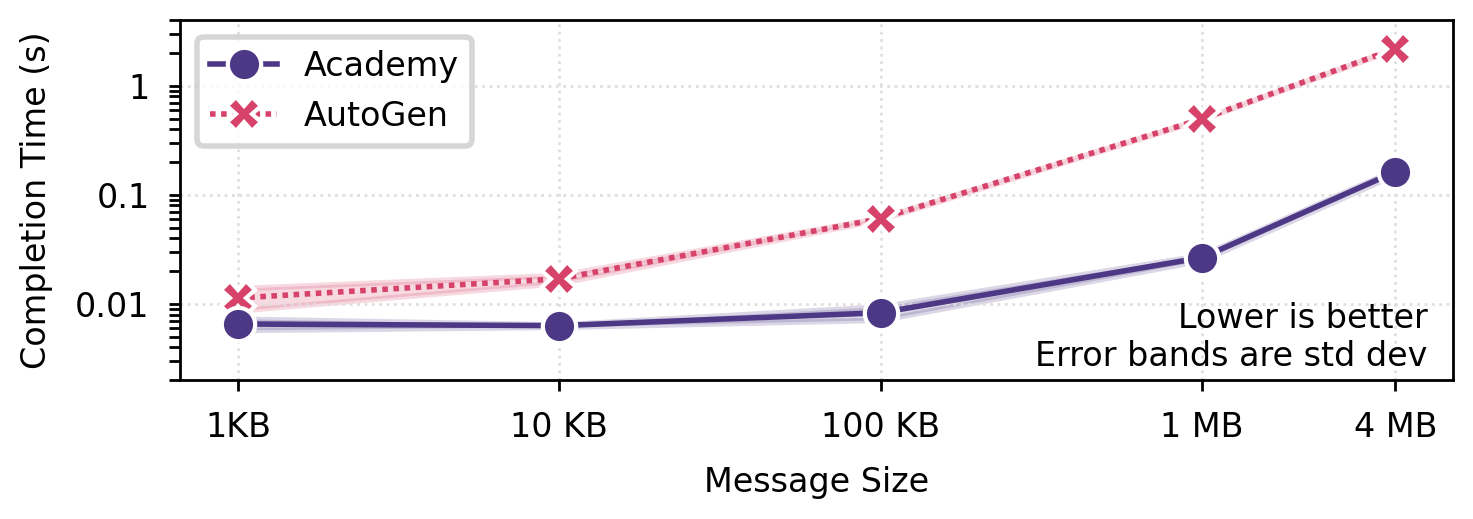

In [25]:
fig, axs = plt.subplots(1, 1)

xticks = sorted(set(runs['size'].to_list()))
xtick_labels = ['1KB', '10 KB', '100 KB', '1 MB', '4 MB']
yticks = [0.01, 0.1, 1]

dashes = {'autogen': (1, 1), 'academy': ()}
markers = {'autogen': 'X', 'academy': 'o'}
palette = {'autogen': '#D64269', 'academy': '#4D3886'}

handle = seaborn.lineplot(
    runs,
    x='size',
    y='time',
    hue='framework',
    hue_order=['autogen', 'academy'],
    style='framework',
    errorbar='sd',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)

handles, _ = axs.get_legend_handles_labels()
axs.legend(
    handles=handles[::-1],
    title=None,
    labels=['Academy', 'AutoGen'],
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Message Size',
    ylabel='Completion Time (s)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels)
axs.tick_params(axis='x', which='minor', bottom=False)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])
axs.set(ylim=[0.002, 4])

axs.annotate(
    'Lower is better\nError bands are std dev',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.5, 1)
fig.savefig('figures/autogen-messaging.pdf')